In [78]:
"""MomentumBuilder vs EfficientSU2 using AnsatzBenchmarking framework"""
%matplotlib inline
import time
import pandas as pd
import numpy as np
import sys
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

notebook_dir = pathlib.Path().resolve()
parent_dir = notebook_dir.parent
sys.path.append(str(parent_dir))

from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

from AnsatzBenchmarking.Builders.momentumBuilder import MomentumBuilder
from AnsatzBenchmarking.Builders.fixedSU2 import FixedSU2Builder as EfficientSU2Builder
from AnsatzBenchmarking.Problems.maxCut.MaxCutProblems import MaxCutProblemSet
from Utilities import cost_func, Estimator
from SLSQP import slsqp

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [79]:
def wrap_cost(cost):
    """Ensure cost_func returns a scalar."""
    if isinstance(cost, np.ndarray):
        return float(cost.item() if cost.size == 1 else cost[0])
    if isinstance(cost, list):
        return float(cost[0] if len(cost) > 0 else 0)
    return float(cost)


def evaluate_builder(builder_class, problem_set, trials=3):
    """Evaluate builder using direct optimization."""
    problems = problem_set.getProblemSet()
    results = []
    estimator = Estimator()
    
    for i, (h, exact) in enumerate(problems):
        print(f"\nProblem {i+1}/{len(problems)}: {h.num_qubits} qubits")
        # For MaxCut: we want to maximize the cut, so we minimize -H
        # Then negate the result to get the maximum cut value
        hamiltonian = -h
        
        for trial in range(trials):
            try:
                builder = builder_class(hamiltonian)
                
                # Build circuit
                start = time.time()
                circuit = builder.getCircuit()
                build_time = time.time() - start
                
                # Optimize
                start = time.time()
                params = np.random.random(len(circuit.parameters))
                opt_result = slsqp(
                    func=lambda p: wrap_cost(cost_func(p, circuit, hamiltonian, estimator)),
                    x0=params,
                    maxiter=200,
                )
                opt_time = time.time() - start
                
                # Negate the result to get maximum cut value
                max_cut_energy = -opt_result.fun
                
                # Map class name to display name
                ansatz_name = builder_class.__name__.replace('Builder', '')
                if ansatz_name == 'FixedSU2':
                    ansatz_name = 'EfficientSU2'
                
                result = {
                    'ansatz_type': ansatz_name,
                    'problem_index': i + 1,
                    'trial': trial + 1,
                    'energy': max_cut_energy,
                    'exact_energy': exact if exact is not None else None,
                    'time': build_time + opt_time,
                    'params': len(circuit.parameters),
                    'converged': opt_result.success,
                }
                results.append(result)
                print(f"  Trial {trial+1}: ✓ Energy: {max_cut_energy:.6f}" + 
                      (f" (exact: {exact:.6f})" if exact is not None else ""))
            except Exception as e:
                print(f"  Trial {trial+1} failed: {str(e)[:50]}")
    
    return results


In [80]:
# Load problem set and run benchmarks
print("Loading MaxCut problem set...")
problem_set = MaxCutProblemSet()
problems = problem_set.getProblemSet()
print(f"Loaded {len(problems)} MaxCut problems\n")

print("Running benchmarks...")
print("="*60)

# Evaluate MomentumBuilder
print("\n" + "="*60)
print("MomentumBuilder:")
print("="*60)
momentum_results = evaluate_builder(MomentumBuilder, problem_set, trials=3)

# Evaluate EfficientSU2
print(f"\n{'='*60}")
print("EfficientSU2:")
print("="*60)
su2_results = evaluate_builder(EfficientSU2Builder, problem_set, trials=3)

# Combine results
all_results = momentum_results + su2_results
df = pd.DataFrame(all_results)
print(f"\n{'='*60}")
print(f"Completed: {len(df)} successful trials")


Loading MaxCut problem set...
Loaded 12 MaxCut problems

Running benchmarks...

MomentumBuilder:

Problem 1/12: 4 qubits
  Trial 1: ✓ Energy: 4.000000 (exact: 4.000000)
  Trial 2: ✓ Energy: 4.000000 (exact: 4.000000)
  Trial 3: ✓ Energy: 4.000000 (exact: 4.000000)

Problem 2/12: 3 qubits
  Trial 1: ✓ Energy: 4.000000 (exact: 4.000000)
  Trial 2: ✓ Energy: 4.000000 (exact: 4.000000)
  Trial 3: ✓ Energy: 4.000000 (exact: 4.000000)

Problem 3/12: 3 qubits
  Trial 1: ✓ Energy: 10.500000 (exact: 11.000000)
  Trial 2: ✓ Energy: 11.000000 (exact: 11.000000)
  Trial 3: ✓ Energy: 11.000000 (exact: 11.000000)

Problem 4/12: 5 qubits
  Trial 1: ✓ Energy: 6.000000 (exact: 6.000000)
  Trial 2: ✓ Energy: 6.000000 (exact: 6.000000)
  Trial 3: ✓ Energy: 6.000000 (exact: 6.000000)

Problem 5/12: 5 qubits
  Trial 1: ✓ Energy: 3.000000 (exact: 4.000000)
  Trial 2: ✓ Energy: 4.000000 (exact: 4.000000)
  Trial 3: ✓ Energy: 4.000000 (exact: 4.000000)

Problem 6/12: 5 qubits
  Trial 1: ✓ Energy: 3.000000 (ex

In [81]:
# Display summary statistics
if len(df) > 0:
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    summary = df.groupby('ansatz_type').agg({
        'energy': ['mean', 'std', 'min', 'max'],
        'time': ['mean', 'std', 'min', 'max'],
        'params': ['mean', 'std'],
        'converged': 'sum'
    })
    print(summary)
    
    # Save results
    df.to_csv("AnsatzComparison.csv", index=False)
    print(f"\nResults saved to AnsatzComparison.csv")
else:
    print("⚠ No successful trials to display.")




SUMMARY STATISTICS
                energy                                time            \
                  mean       std       min   max      mean       std   
ansatz_type                                                            
EfficientSU2  8.499998  4.907721  3.999997  21.0  0.658852  0.429937   
Momentum      8.319444  5.001647  3.000000  21.0  0.115350  0.068315   

                                     params           converged  
                   min       max       mean       std       sum  
ansatz_type                                                      
EfficientSU2  0.156103  2.046008  29.000000  8.176622        36  
Momentum      0.038461  0.316839   8.833333  1.362770        36  

Results saved to AnsatzComparison.csv


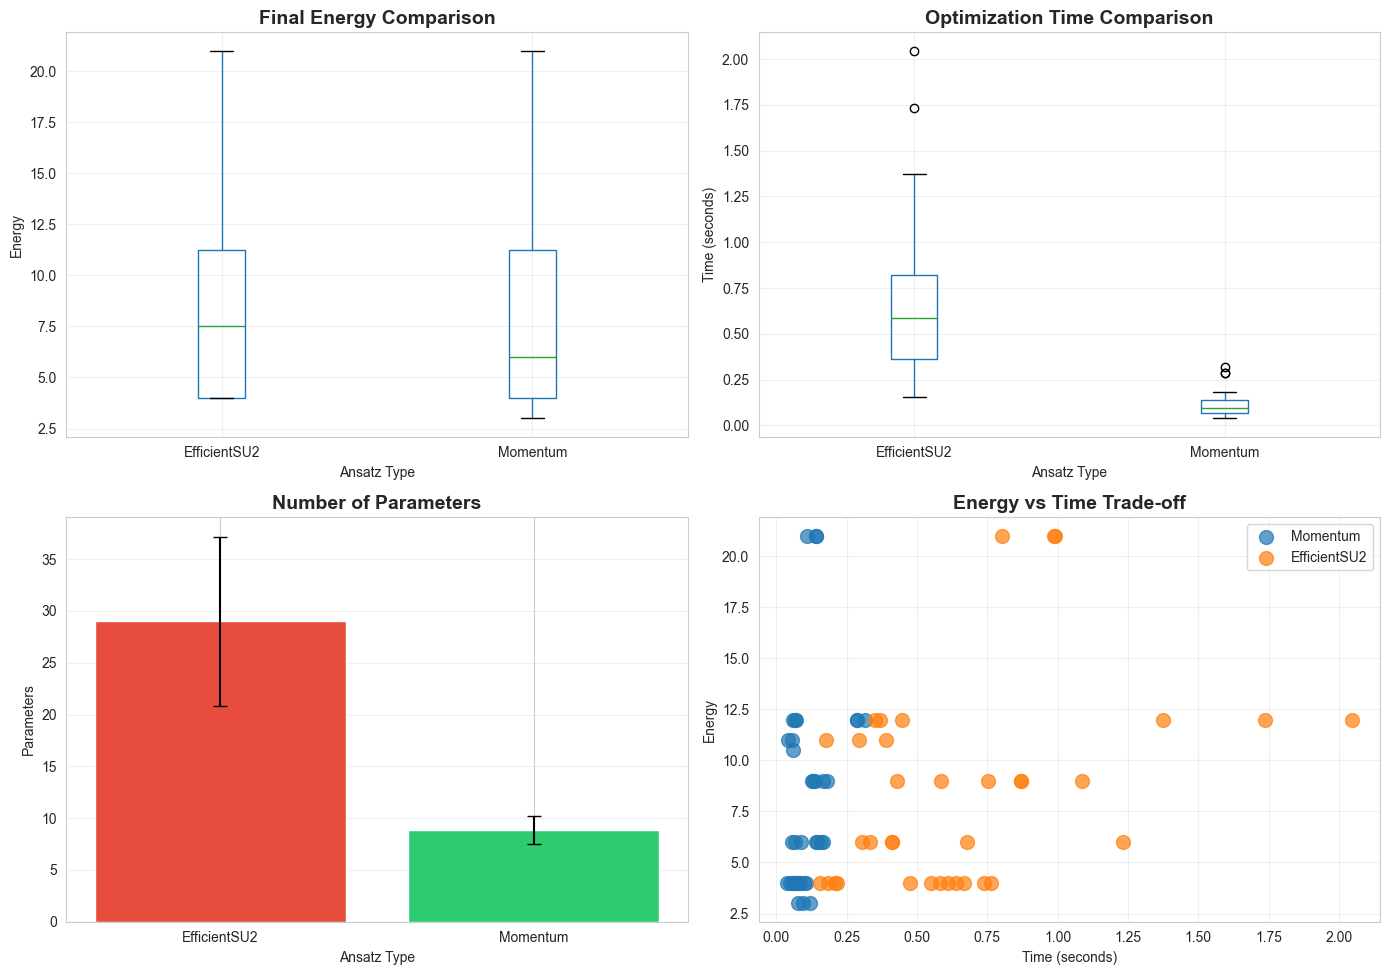

In [82]:
# Visualization 1: Main comparison plots
if len(df) > 0 and 'ansatz_type' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Energy comparison
    ax1 = axes[0, 0]
    df.boxplot(column='energy', by='ansatz_type', ax=ax1)
    ax1.set_title('Final Energy Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Ansatz Type')
    ax1.set_ylabel('Energy')
    ax1.grid(True, alpha=0.3)
    plt.suptitle('')
    
    # 2. Time comparison
    ax2 = axes[0, 1]
    df.boxplot(column='time', by='ansatz_type', ax=ax2)
    ax2.set_title('Optimization Time Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Ansatz Type')
    ax2.set_ylabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)
    plt.suptitle('')
    
    # 3. Parameters comparison
    ax3 = axes[1, 0]
    param_means = df.groupby('ansatz_type')['params'].mean()
    param_stds = df.groupby('ansatz_type')['params'].std()
    x_pos = np.arange(len(param_means))
    ax3.bar(x_pos, param_means.values, yerr=param_stds.values, 
            color=['#e74c3c', '#2ecc71'], capsize=5)
    ax3.set_title('Number of Parameters', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Ansatz Type')
    ax3.set_ylabel('Parameters')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(param_means.index, rotation=0)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Energy vs Time scatter
    ax4 = axes[1, 1]
    for ansatz_type in df['ansatz_type'].unique():
        subset = df[df['ansatz_type'] == ansatz_type]
        ax4.scatter(subset['time'], subset['energy'], 
                   label=ansatz_type, alpha=0.7, s=100)
    ax4.set_title('Energy vs Time Trade-off', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Energy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ansatz_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


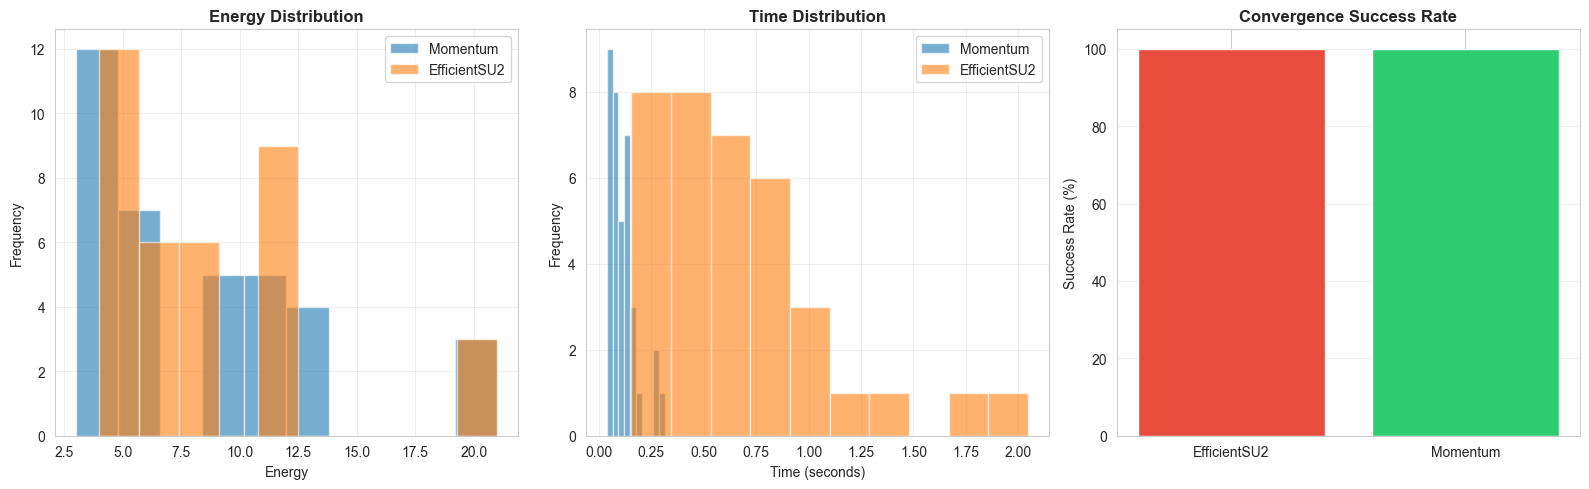

In [83]:
# Visualization 2: Detailed comparison plots
if len(df) > 0 and 'ansatz_type' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Energy distribution
    ax1 = axes[0]
    for ansatz_type in df['ansatz_type'].unique():
        subset = df[df['ansatz_type'] == ansatz_type]
        ax1.hist(subset['energy'], alpha=0.6, label=ansatz_type, bins=10)
    ax1.set_xlabel('Energy')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Energy Distribution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Time distribution
    ax2 = axes[1]
    for ansatz_type in df['ansatz_type'].unique():
        subset = df[df['ansatz_type'] == ansatz_type]
        ax2.hist(subset['time'], alpha=0.6, label=ansatz_type, bins=10)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Time Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Success rate
    ax3 = axes[2]
    success_rate = df.groupby('ansatz_type')['converged'].agg(['sum', 'count'])
    success_rate['rate'] = success_rate['sum'] / success_rate['count'] * 100
    x_pos = np.arange(len(success_rate))
    ax3.bar(x_pos, success_rate['rate'].values, color=['#e74c3c', '#2ecc71'])
    ax3.set_ylabel('Success Rate (%)')
    ax3.set_title('Convergence Success Rate', fontsize=12, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(success_rate.index, rotation=0)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim([0, 105])
    
    plt.tight_layout()
    plt.savefig('ansatz_detailed_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()



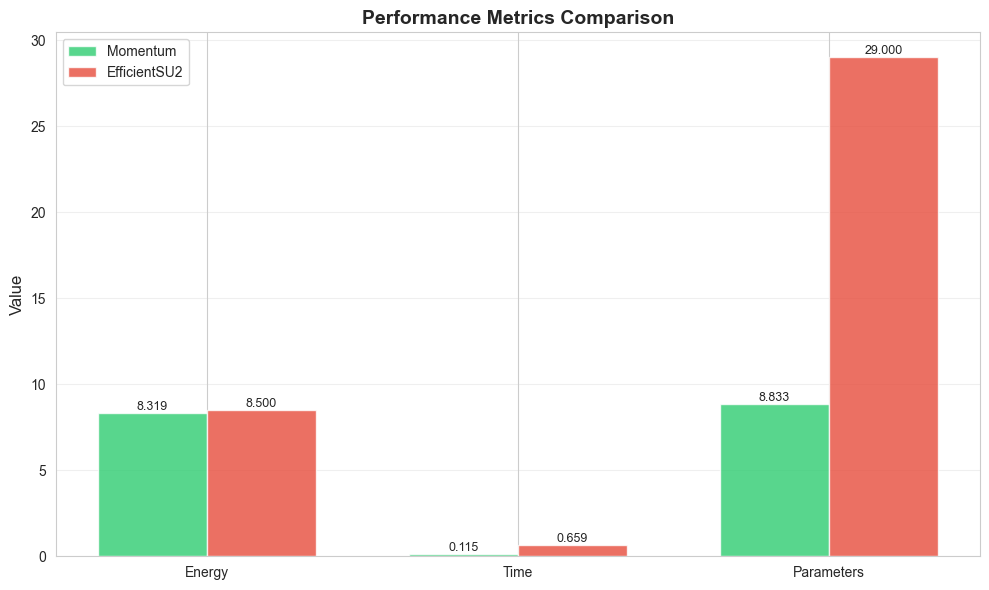


PERFORMANCE IMPROVEMENTS
✓ MomentumBuilder achieves 2.12% lower energy
✓ MomentumBuilder is 5.71x faster
✓ MomentumBuilder uses 69.5% fewer parameters


In [84]:
# Visualization 3: Performance metrics comparison
if len(df) > 0 and 'ansatz_type' in df.columns:
    momentum = df[df['ansatz_type'] == 'Momentum']
    su2 = df[df['ansatz_type'] == 'EfficientSU2']
    
    if len(momentum) > 0 and len(su2) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        metrics = ['Energy', 'Time', 'Parameters']
        momentum_vals = [
            momentum['energy'].mean(),
            momentum['time'].mean(),
            momentum['params'].mean()
        ]
        su2_vals = [
            su2['energy'].mean(),
            su2['time'].mean(),
            su2['params'].mean()
        ]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, momentum_vals, width, label='Momentum', 
                      color='#2ecc71', alpha=0.8)
        bars2 = ax.bar(x + width/2, su2_vals, width, label='EfficientSU2', 
                      color='#e74c3c', alpha=0.8)
        
        ax.set_ylabel('Value', fontsize=12)
        ax.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('ansatz_metrics_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print improvements
        e_improve = ((su2['energy'].mean() - momentum['energy'].mean()) / abs(su2['energy'].mean())) * 100
        t_speedup = su2['time'].mean() / momentum['time'].mean()
        p_reduction = ((su2['params'].mean() - momentum['params'].mean()) / su2['params'].mean()) * 100
        
        print("\n" + "="*60)
        print("PERFORMANCE IMPROVEMENTS")
        print("="*60)
        if e_improve > 0:
            print(f"✓ MomentumBuilder achieves {e_improve:.2f}% lower energy")
        else:
            print(f"✗ EfficientSU2 achieves {abs(e_improve):.2f}% lower energy")
        
        if t_speedup > 1:
            print(f"✓ MomentumBuilder is {t_speedup:.2f}x faster")
        else:
            print(f"✗ EfficientSU2 is {1/t_speedup:.2f}x faster")
        
        if p_reduction > 0:
            print(f"✓ MomentumBuilder uses {p_reduction:.1f}% fewer parameters")
        else:
            print(f"✗ EfficientSU2 uses {abs(p_reduction):.1f}% fewer parameters")
